### Imports

In [1]:
pip install annoy

     |████████████████████████████████| 646 kB 4.2 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391666 sha256=726b477ebb634be457759f978892d2e709bef41009ff45186705378ec4fc8aeb
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

np.random.seed(42)
torch.cuda.set_device(0)

from annoy import AnnoyIndex

import glob

In [3]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Creating DFs

In [5]:
#creating df of image names & dataset label (train, val, test)
img_partitions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/Eval/list_eval_partition.csv', sep="\t", header=1, error_bad_lines=False, encoding="euc-kr")
img_partitions['path'] = img_partitions['path'].replace("K-Fashion 이미지/원천데이터/레트로/","")
img_partitions

path evaluation_status
0                K-Fashion 이미지/원천데이터/레트로/(121)IMG_1.jpg               val
1                K-Fashion 이미지/원천데이터/레트로/(211)IMG_1.jpg               val
2     K-Fashion 이미지/원천데이터/레트로/018-285-4,257-35,865-H...               val
3     K-Fashion 이미지/원천데이터/레트로/019-286-3,261-39,126-H...             train
4     K-Fashion 이미지/원천데이터/레트로/1-(9)-004-271-3031-516...               val
...                                                 ...               ...
1176  K-Fashion 이미지/원천데이터/레트로/없음-994-994-완-DSC_4876.jpg             train
1177  K-Fashion 이미지/원천데이터/레트로/없음-994-994-완-DSC_4896.jpg             train
1178  K-Fashion 이미지/원천데이터/레트로/없음-994-994-완-DSC_4916.jpg               val
1179  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...              test
1180  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...             train

[1181 rows x 2 columns]

In [6]:
'''
#creating df of image names & dataset label (train, val, test)
img_partitions = pd.read_csv('./Eval/list_eval_partition.txt', delim_whitespace=True, header=1)

#creating df of attribute names and type label
attributes = pd.read_csv(
    './Anno/list_attr_cloth.txt', 
    sep='\s{2,}', 
    header=0, 
    skiprows=[0], 
    engine='python')

attributes_imgs = pd.read_csv(
    './Anno/list_attr_img.txt', 
    delim_whitespace=True, 
    header=0,
    skiprows=[0],
    names=(['image_name'] + attributes['attribute_name'].tolist()))
attributes_imgs.replace([-1,0,1],[False,False,True], inplace=True)

#creating df of image names, attribute tags, and dataset label
attributes_df = attributes_imgs.merge(img_partitions, how ='left', on='image_name')'''

#creating df of attribute names and type label
attributes = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/Anno/list_attr_cloth.txt', 
    sep='\s{2,}', header=0, skiprows=[0], engine='python')
attributes.rename(columns={'material': 'length'},inplace = True)
attributes

length  attribute_type
0         비즈               1
1         단추               1
2      니트꽈배기               1
3         체인               1
4        컷오프               1
5    더블브레스티드               1
6       드롭숄더               1
7         자수               1
8         프릴               1
9        프린지               1
10       플레어               1
11        퀼팅               1
12        리본               1
13        롤업               1
14        러플               1
15        셔링               1
16        슬릿               1
17       스팽글               1
18       스티치               1
19       스터드               1
20      퍼트리밍               1
21       글리터               1
22        후드               1
23      레이스업               1
24        패딩               1
25      패치워크               1
26       페플럼               1
27       플리츠               1
28        포켓               1
29        폼폼               1
30        퍼프               1
31        태슬               1
32        집업               1
33         띠               1
34    디스트로이드               1
35    드롭웨이스트               1
36        버클               1
37       컷아웃               1
38      X스트랩               1
39       비대칭               1
40        셔링               1
41        체크               2
42     스트라이프               2
43      지그재그               2
44        호피               2
45       지브라               2
46        도트               2
47     카무플라쥬               2
48      페이즐리               2
49       아가일               2
50       플로럴               2
51       레터링               2
52        해골               2
53      타이다이               2
54     그라데이션               2
55        무지               2
56       그래픽               2
57    하운즈 투스               2
58        깅엄               2
59         퍼               3
60       무스탕               3
61      스웨이드               3
62       앙고라               3
63      코듀로이               3
64    시퀸/글리터               3
65        우븐               3
66        데님               3
67        저지               3
68       트위드               3
69        벨벳               3
70    비닐/PVC               3
71    울/캐시미어               3
72      합성섬유               3
73        니트               3
74       레이스               3
75        린넨               3
76        메시               3
77       플리스               3
78      네오프렌               3
79        실크               3
80      스판덱스               3
81       자카드               3
82        가죽               3
83         면               3
84        시폰               3
85       민소매               4
86        반팔               4
87         캡               4
88      7부소매               4
89        긴팔               4
90      라운드넥               5
91        유넥               5
92       브이넥               5
93       홀터넥               5
94      오프숄더               5
95      원 숄더               5
96      스퀘어넥               5
97       노카라               5
98        후드               5
99       터틀넥               5
100      보트넥               5
101    스위트하트               5
102     셔츠칼라               6
103     보우칼라               6
104    세일러칼라               6
105      숄칼라               6
106     폴로칼라               6
107    피터팬칼라               6
108    너치드칼라               6
109    차이나칼라               6
110   테일러드칼라               6
111     밴드칼라               6
112       노멀               7
113       루즈               7
114    오버사이즈               7
115      스키니               7
116      와이드               7
117      타이트               7
118      페플럼               8
119      비대칭               8
120     알수없음               8
121       펜슬               8
122      A라인               8
123      H라인               8
124     머메이드               8
125  벨보텀/플레어               8
126      부츠컷               8
127     테이퍼드               8
128    스트레이트               8

In [7]:
attributes_imgs = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/Anno/list_img.csv', 
   sep="\t", skiprows=[0],header=0, error_bad_lines=False, encoding="euc-kr",engine='python'
    )

# for data in attributes_imgs['material'] :
def img(x):
  if type(x) != str:
    return ""
  x = x.replace("['", "").replace("']", "").replace("', '", ",").split(",")
  return x[0]

attributes_imgs['material'] = attributes_imgs['material'].apply(lambda x: img(x))

attributes_imgs['print'] =  attributes_imgs['print'].apply(lambda x: img(x))

attributes_imgs['detail'] =  attributes_imgs['detail'].apply(lambda x: img(x))

attributes_imgs


path clothes  \
0                K-Fashion 이미지/원천데이터/레트로/(121)IMG_1.jpg      상의   
1                K-Fashion 이미지/원천데이터/레트로/(211)IMG_1.jpg      상의   
2     K-Fashion 이미지/원천데이터/레트로/018-285-4,257-35,865-H...     원피스   
3     K-Fashion 이미지/원천데이터/레트로/019-286-3,261-39,126-H...      상의   
4     K-Fashion 이미지/원천데이터/레트로/1-(9)-004-271-3031-516...      상의   
...                                                 ...     ...   
1176  K-Fashion 이미지/원천데이터/레트로/없음-994-994-완-DSC_4876.jpg     원피스   
1177  K-Fashion 이미지/원천데이터/레트로/없음-994-994-완-DSC_4896.jpg     원피스   
1178  K-Fashion 이미지/원천데이터/레트로/없음-994-994-완-DSC_4916.jpg     원피스   
1179  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...      상의   
1180  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...      하의   

                                        name category color detail print  \
0                             (121)IMG_1.jpg     블라우스   네이비          플로럴   
1                             (211)IMG_1.jpg     블라우스   베이지    페플럼   플로럴   
2      018-285-4,257-35,865-Hanna_409_07.jpg      드레스   화이트     퍼프    깅엄   
3     019-286-3,261-39,126-Haemil_194_06.jpg     니트웨어    와인           무지   
4     1-(9)-004-271-3031-5163-TOP_179_11.jpg     블라우스   화이트          그래픽   
...                                      ...      ...   ...    ...   ...   
1176               없음-994-994-완-DSC_4876.jpg      드레스    와인    플레어   플로럴   
1177               없음-994-994-완-DSC_4896.jpg      드레스    와인    플레어   플로럴   
1178               없음-994-994-완-DSC_4916.jpg      드레스    와인    플레어   플로럴   
1179      팬츠-1-u_155677953310-001 (1995).jpg     니트웨어   베이지          아가일   
1180      팬츠-1-u_155677953310-001 (1995).jpg       팬츠    핑크     롤업         

     material length neckline  collar fit  shape  
0          우븐     긴팔      NaN     NaN  루즈    NaN  
1          시폰     긴팔      NaN     NaN  노멀    NaN  
2          우븐     반팔    스위트하트     NaN  루즈    NaN  
3          니트   7부소매      터틀넥     NaN  노멀    NaN  
4          우븐   7부소매     라운드넥     NaN  루즈    NaN  
...       ...    ...      ...     ...  ..    ...  
1176       우븐     긴팔      NaN     NaN  노멀    NaN  
1177       우븐     긴팔      NaN     NaN  노멀    NaN  
1178       우븐     긴팔      NaN     NaN  노멀    NaN  
1179       니트     긴팔     라운드넥     NaN  노멀    NaN  
1180       우븐    NaN      NaN     NaN  노멀    NaN  

[1181 rows x 13 columns]

In [8]:
#creating df of image names, attribute tags, and dataset label
#attributes_imgs.replace([-1,0,1],[False,False,True], inplace=True)
attributes_imgs = pd.merge(attributes_imgs, attributes, how='left', on='length')
attributes_df = pd.merge(attributes_imgs, img_partitions, how='left', on='path')

attributes_df

path clothes  \
0                K-Fashion 이미지/원천데이터/레트로/(121)IMG_1.jpg      상의   
1                K-Fashion 이미지/원천데이터/레트로/(211)IMG_1.jpg      상의   
2     K-Fashion 이미지/원천데이터/레트로/018-285-4,257-35,865-H...     원피스   
3     K-Fashion 이미지/원천데이터/레트로/019-286-3,261-39,126-H...      상의   
4     K-Fashion 이미지/원천데이터/레트로/1-(9)-004-271-3031-516...      상의   
...                                                 ...     ...   
1930  K-Fashion 이미지/원천데이터/레트로/없음-994-994-완-DSC_4916.jpg     원피스   
1931  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...      상의   
1932  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...      상의   
1933  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...      하의   
1934  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...      하의   

                                        name category color detail print  \
0                             (121)IMG_1.jpg     블라우스   네이비          플로럴   
1                             (211)IMG_1.jpg     블라우스   베이지    페플럼   플로럴   
2      018-285-4,257-35,865-Hanna_409_07.jpg      드레스   화이트     퍼프    깅엄   
3     019-286-3,261-39,126-Haemil_194_06.jpg     니트웨어    와인           무지   
4     1-(9)-004-271-3031-5163-TOP_179_11.jpg     블라우스   화이트          그래픽   
...                                      ...      ...   ...    ...   ...   
1930               없음-994-994-완-DSC_4916.jpg      드레스    와인    플레어   플로럴   
1931      팬츠-1-u_155677953310-001 (1995).jpg     니트웨어   베이지          아가일   
1932      팬츠-1-u_155677953310-001 (1995).jpg     니트웨어   베이지          아가일   
1933      팬츠-1-u_155677953310-001 (1995).jpg       팬츠    핑크     롤업         
1934      팬츠-1-u_155677953310-001 (1995).jpg       팬츠    핑크     롤업         

     material length neckline  collar fit  shape  attribute_type  \
0          우븐     긴팔      NaN     NaN  루즈    NaN             4.0   
1          시폰     긴팔      NaN     NaN  노멀    NaN             4.0   
2          우븐     반팔    스위트하트     NaN  루즈    NaN             4.0   
3          니트   7부소매      터틀넥     NaN  노멀    NaN             4.0   
4          우븐   7부소매     라운드넥     NaN  루즈    NaN             4.0   
...       ...    ...      ...     ...  ..    ...             ...   
1930       우븐     긴팔      NaN     NaN  노멀    NaN             4.0   
1931       니트     긴팔     라운드넥     NaN  노멀    NaN             4.0   
1932       니트     긴팔     라운드넥     NaN  노멀    NaN             4.0   
1933       우븐    NaN      NaN     NaN  노멀    NaN             NaN   
1934       우븐    NaN      NaN     NaN  노멀    NaN             NaN   

     evaluation_status  
0                  val  
1                  val  
2                  val  
3                train  
4                  val  
...                ...  
1930               val  
1931              test  
1932             train  
1933              test  
1934             train  

[1935 rows x 15 columns]

In [9]:
#removing images from DF with no label
#training_df['max'] = [training_df.iloc[x][1:].max() for x in training_df.index.tolist()]
#training_df = training_df[training_df['max'].isin([True])].copy()
#training_df.drop('max', axis=1, inplace=True)
attributes_df['length']=attributes_df['length'].dropna()
attributes_df

path clothes  \
0                K-Fashion 이미지/원천데이터/레트로/(121)IMG_1.jpg      상의   
1                K-Fashion 이미지/원천데이터/레트로/(211)IMG_1.jpg      상의   
2     K-Fashion 이미지/원천데이터/레트로/018-285-4,257-35,865-H...     원피스   
3     K-Fashion 이미지/원천데이터/레트로/019-286-3,261-39,126-H...      상의   
4     K-Fashion 이미지/원천데이터/레트로/1-(9)-004-271-3031-516...      상의   
...                                                 ...     ...   
1930  K-Fashion 이미지/원천데이터/레트로/없음-994-994-완-DSC_4916.jpg     원피스   
1931  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...      상의   
1932  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...      상의   
1933  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...      하의   
1934  K-Fashion 이미지/원천데이터/레트로/팬츠-1-u_155677953310-00...      하의   

                                        name category color detail print  \
0                             (121)IMG_1.jpg     블라우스   네이비          플로럴   
1                             (211)IMG_1.jpg     블라우스   베이지    페플럼   플로럴   
2      018-285-4,257-35,865-Hanna_409_07.jpg      드레스   화이트     퍼프    깅엄   
3     019-286-3,261-39,126-Haemil_194_06.jpg     니트웨어    와인           무지   
4     1-(9)-004-271-3031-5163-TOP_179_11.jpg     블라우스   화이트          그래픽   
...                                      ...      ...   ...    ...   ...   
1930               없음-994-994-완-DSC_4916.jpg      드레스    와인    플레어   플로럴   
1931      팬츠-1-u_155677953310-001 (1995).jpg     니트웨어   베이지          아가일   
1932      팬츠-1-u_155677953310-001 (1995).jpg     니트웨어   베이지          아가일   
1933      팬츠-1-u_155677953310-001 (1995).jpg       팬츠    핑크     롤업         
1934      팬츠-1-u_155677953310-001 (1995).jpg       팬츠    핑크     롤업         

     material length neckline  collar fit  shape  attribute_type  \
0          우븐     긴팔      NaN     NaN  루즈    NaN             4.0   
1          시폰     긴팔      NaN     NaN  노멀    NaN             4.0   
2          우븐     반팔    스위트하트     NaN  루즈    NaN             4.0   
3          니트   7부소매      터틀넥     NaN  노멀    NaN             4.0   
4          우븐   7부소매     라운드넥     NaN  루즈    NaN             4.0   
...       ...    ...      ...     ...  ..    ...             ...   
1930       우븐     긴팔      NaN     NaN  노멀    NaN             4.0   
1931       니트     긴팔     라운드넥     NaN  노멀    NaN             4.0   
1932       니트     긴팔     라운드넥     NaN  노멀    NaN             4.0   
1933       우븐    NaN      NaN     NaN  노멀    NaN             NaN   
1934       우븐    NaN      NaN     NaN  노멀    NaN             NaN   

     evaluation_status  
0                  val  
1                  val  
2                  val  
3                train  
4                  val  
...                ...  
1930               val  
1931              test  
1932             train  
1933              test  
1934             train  

[1935 rows x 15 columns]

In [10]:
'''
#create list of column names to keep for training
# 1 = Texture, 2 = Fabric, 3 = Shape, 4 = Parts, 5 = Style
list_attr_names = ['image_name']+attributes[(attributes['attribute_type']==4)]['attribute_name'].tolist()
training_df = attributes_df[attributes_df['evaluation_status'].isin(['train','val'])][list_attr_names].copy()
training_df.reset_index(drop=True, inplace=True)
'''

"\n#create list of column names to keep for training\n# 1 = Texture, 2 = Fabric, 3 = Shape, 4 = Parts, 5 = Style\nlist_attr_names = ['image_name']+attributes[(attributes['attribute_type']==4)]['attribute_name'].tolist()\ntraining_df = attributes_df[attributes_df['evaluation_status'].isin(['train','val'])][list_attr_names].copy()\ntraining_df.reset_index(drop=True, inplace=True)\n"

In [11]:
'''
#removing images from DF with no label
training_df['max'] = [training_df.iloc[x][1:].max() for x in training_df.index.tolist()]
training_df = training_df[training_df['max'].isin([True])].copy()
training_df.drop('max', axis=1, inplace=True)
'''

"\n#removing images from DF with no label\ntraining_df['max'] = [training_df.iloc[x][1:].max() for x in training_df.index.tolist()]\ntraining_df = training_df[training_df['max'].isin([True])].copy()\ntraining_df.drop('max', axis=1, inplace=True)\n"

## Baseline Model (No Data Cleaning)

In [12]:
from fastai import *
from fastai.vision import *

np.random.seed(42)
torch.cuda.set_device(0)

In [13]:
training_df = attributes_df[attributes_df['evaluation_status'].isin(['train','val'])][['length','name']].copy()

#One Hot Encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

X = training_df.iloc[:, :].values
X= pd.DataFrame(X, columns=['length','name'])
print(X)
'''
le = LabelEncoder()
print('****************************')
X[0] = le.fit_transform(X[0])
print(X)

ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), [0])],   # The column numbers to be transformed (here is [0] but can be [0, 1, 3])
    remainder='passthrough'                                         # Leave the rest of the columns untouched
)
print('****************************')
X = ct.fit_transform(X[0]).toarray()
print(X)
'''

pandas_one_hot_encoded = pd.get_dummies(X['length'])

pandas_with_onehot = pd.concat(
    [DataFrame(X['name']),pandas_one_hot_encoded],axis=1)
pandas_with_onehot.replace([-1,0,1],[False,False,True], inplace=True)
print(pandas_with_onehot)


pandas_with_onehot.to_csv('/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/Anno/OHEmaterial.csv', mode='w',encoding='utf-8-sig', header=True)
'''
csvfile = open('/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/Anno/OHEmaterial.csv', 
   "w",newline="")

csvwriter = csv.writer(csvfile)
for rows in pandas_with_onehot :
  csvwriter.writerows(rows)

csvfile.close()
'''
'''
training_df = attributes_df[attributes_df['evaluation_status'].isin(['train','val'])][['name']].copy()
print(training_df)
print('****************************')
OHE_df = pd.concat(training_df, ohe)
OHE_df
'''
ohe = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/Anno/OHEmaterial.csv'
    )
print(ohe)
ohe=ohe.drop([ohe.columns[0],ohe.columns[2]],axis=1)
ohe

#attributes_df2 = ohe.merge(attributes_df, how ='left', on='name')
#attributes_df2

#training_df2 = attributes_df2[attributes_df2['evaluation_status'].isin(['train','val'])].copy()
#training_df2.reset_index(drop=True, inplace=True)
#training_df2 = training_df2.drop([training_df2.columns[19],training_df2.columns[20],training_df2.columns[21],training_df2.columns[22],training_df2.columns[23],training_df2.columns[24],training_df2.columns[25],training_df2.columns[26],training_df2.columns[27],training_df2.columns[28],training_df2.columns[29],training_df2.columns[30],training_df2.columns[31],training_df2.columns[32],training_df2.columns[33]],axis=1)
#training_df2

     length                                    name
0        긴팔                          (121)IMG_1.jpg
1        긴팔                          (211)IMG_1.jpg
2        반팔   018-285-4,257-35,865-Hanna_409_07.jpg
3      7부소매  019-286-3,261-39,126-Haemil_194_06.jpg
4      7부소매  1-(9)-004-271-3031-5163-TOP_179_11.jpg
...     ...                                     ...
1315     긴팔               없음-994-994-완-DSC_4876.jpg
1316     긴팔               없음-994-994-완-DSC_4896.jpg
1317     긴팔               없음-994-994-완-DSC_4916.jpg
1318     긴팔      팬츠-1-u_155677953310-001 (1995).jpg
1319    NaN      팬츠-1-u_155677953310-001 (1995).jpg

[1320 rows x 2 columns]
                                        name   7부소매     긴팔    민소매     반팔  \
0                             (121)IMG_1.jpg  False   True  False  False   
1                             (211)IMG_1.jpg  False   True  False  False   
2      018-285-4,257-35,865-Hanna_409_07.jpg  False  False  False   True   
3     019-286-3,261-39,126-Haemil_194_06.jpg   

name     긴팔    민소매     반팔     없음  \
0                             (121)IMG_1.jpg   True  False  False  False   
1                             (211)IMG_1.jpg   True  False  False  False   
2      018-285-4,257-35,865-Hanna_409_07.jpg  False  False   True  False   
3     019-286-3,261-39,126-Haemil_194_06.jpg  False  False  False  False   
4     1-(9)-004-271-3031-5163-TOP_179_11.jpg  False  False  False  False   
...                                      ...    ...    ...    ...    ...   
1315               없음-994-994-완-DSC_4876.jpg   True  False  False  False   
1316               없음-994-994-완-DSC_4896.jpg   True  False  False  False   
1317               없음-994-994-완-DSC_4916.jpg   True  False  False  False   
1318      팬츠-1-u_155677953310-001 (1995).jpg   True  False  False  False   
1319      팬츠-1-u_155677953310-001 (1995).jpg  False  False  False  False   

          캡  
0     False  
1     False  
2     False  
3     False  
4     False  
...     ...  
1315  False  
1316  False  
1317  False  
1318  False  
1319  False  

[1320 rows x 6 columns]

In [14]:
def count_attr_imgs(attr_df):
    col_counts = {}

    for col in attr_df.columns[1:]:
        col_counts[col] = attr_df[col].value_counts().to_frame().loc[True][0]
    
    col_df = pd.DataFrame.from_dict(col_counts, orient='index', columns=['Count'])
    
    return col_df
#.sort_values(by='Count')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44596 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48124 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_

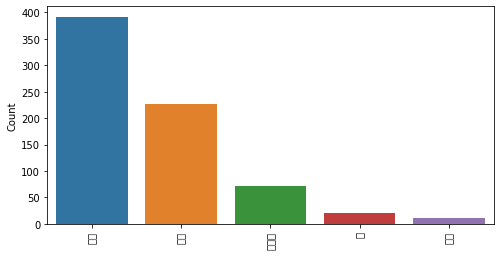

In [15]:
plt.figure(figsize=(8,4))
sns.barplot(x=count_attr_imgs(ohe).sort_values(by='Count',ascending=False).index,y=count_attr_imgs(ohe).sort_values(by='Count',ascending=False)['Count'])
plt.xticks(rotation=90);

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44596 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48124 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_

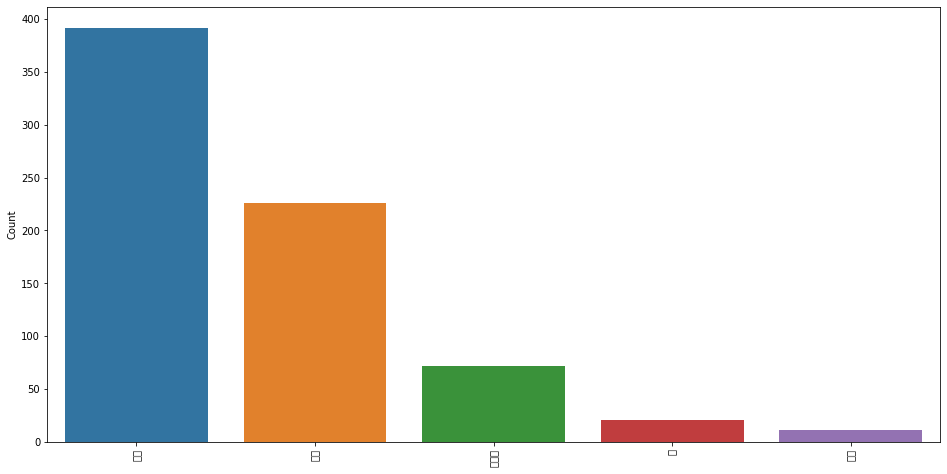

In [16]:
plt.figure(figsize=(16,8))
sns.barplot(x=count_attr_imgs(ohe).sort_values(by='Count',ascending=False)[:25].index,y=count_attr_imgs(ohe).sort_values(by='Count',ascending=False)[:25]['Count'])
plt.xticks(rotation=90);

In [17]:
# take all the columns after the first "image_name" col
label_column_names = ohe.columns.tolist()[1:]
label_column_names


img_base_path = Path("/content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/K-Fashion 이미지/원천데이터/레트로/")
data = ImageDataBunch.from_df(img_base_path, ohe, ds_tfms=get_transforms(), size=150,label_col=label_column_names)
data.normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

ImageDataBunch;

Train: LabelList (1056 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: MultiCategoryList
긴팔,긴팔,반팔,,
Path: /content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/K-Fashion 이미지/원천데이터/레트로;

Valid: LabelList (264 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: MultiCategoryList
반팔,,없음,긴팔,
Path: /content/drive/MyDrive/Colab Notebooks/FashionRecommendations/CNN/K-Fashion 이미지/원천데이터/레트로;

Test: None

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

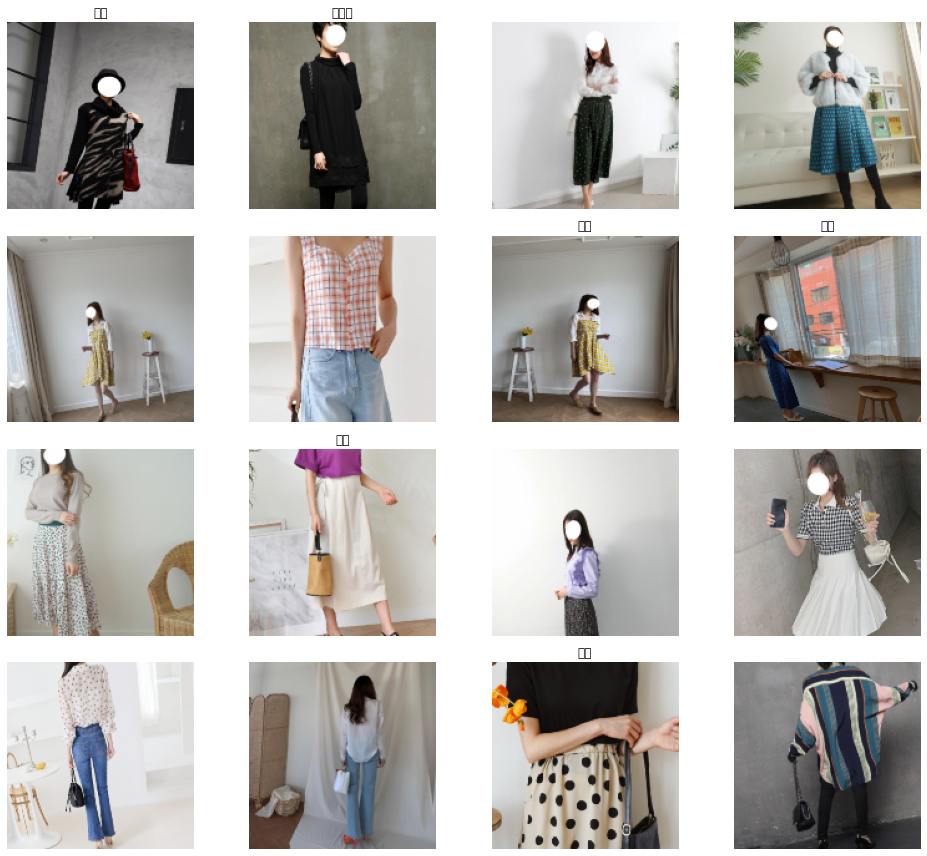

In [18]:
data.show_batch(rows=4, figsize=(14,12),)

In [19]:
print(data.classes)
len(data.classes),data.c


(5, 5)

['긴팔', '민소매', '반팔', '없음', '캡']


In [20]:
acc_02 = partial(accuracy_thresh, thresh=0.1)
f_score = partial(fbeta, thresh=0.1)

In [21]:
learn = cnn_learner(data, models.resnet50, metrics=[acc_02, f_score], callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

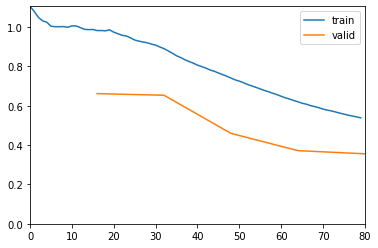

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for i

In [22]:
learn.fit_one_cycle(5)

In [23]:
learn.lr_find()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for i

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


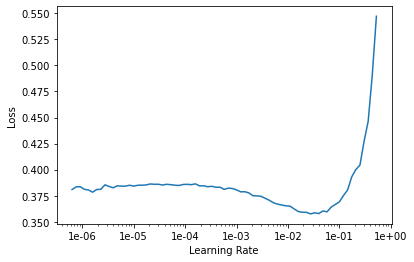

In [24]:
learn.recorder.plot()

In [25]:
learn.unfreeze()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

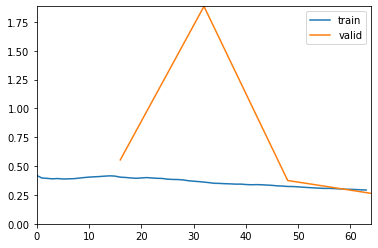

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for i

In [26]:
learn.fit_one_cycle(4, slice(1e-4,1e-2))

In [27]:
learn.save('parts-resnet50-size150-fr5-unfr4', return_path=True)
learn.export('parts-resnet50-size150-fr5-unfr4.pkl')

In [28]:
predict_img_path = "floral_dress.jpg" 
category,classIndex,losses = learn.predict(open_image(predict_img_path))
predictions = sorted(zip(data.classes, map(float, losses)), key=lambda p: p[1], reverse=True)
print (predictions[:5])
show_image(open_image(predict_img_path))

# "/data/Michael/data/predict/2.png"

FileNotFoundError: ignored